# Cassini Cosmic Dust Analyzer - Project 1: Calibrating CDA

## Part 5: Multi-Output Regression + Keras Tuner

Our second to last project script takes a look at how to create multi-output regression models. Here, we will take IID impacts and consider QT, as well as QI signals with a rise time and amplitude larger 0. 4 input values will map to 2 output values: a particle's velocity and mass.

Although this problem is quite straight-forward for a keras regression task, we will use Keras Tuner to optimize our network architecture. You can take it as a "blue print" for other or future projects. Further, we add some new functionalities in Keras Tuner that will enable us to conduct K-Fold cross validation trainings in this hyper-parameter optimization process.

## Read in and split the data

In [1]:
# Import default libraries
import pathlib
import zipfile

# Import installed libraries
import keras_tuner
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.model_selection
import tensorflow as tf

# Matplotlib darkmode
plt.style.use('dark_background')

# Styling
plt.rcParams.update({
    "font.size": 14
})

In [2]:
# Read in the level 1 data
cal_df = pd.read_pickle("data/level1/CDA__CAT_IID_cal_data.pkl")

In [3]:
# In our example we'll only consider IID QI data
iid_qi_cal_df = cal_df.loc[(cal_df["TAR"] == "IID")
                           & (cal_df["QI_CHARGE"] > 0.0)
                           & (cal_df["QI_TR"] > 0.0)
                           & (cal_df["QT_CHARGE"] > 0.0)
                           & (cal_df["QT_TR"] > 0.0)].copy()

# Adding the LOG10 scaled data of the QI channel
iid_qi_cal_df.loc[:, "QI_LOG10_fC"] = np.log10(iid_qi_cal_df["QI_CHARGE"])
iid_qi_cal_df.loc[:, "QT_LOG10_fC"] = np.log10(iid_qi_cal_df["QT_CHARGE"])

# Convert the mass and apply log10, too
iid_qi_cal_df.loc[:, "MASS_LOG10_fg"] = np.log10(iid_qi_cal_df["MASS"] / 10e-15)

# Rename the rise times and velocity
iid_qi_cal_df.rename(columns={"QI_TR": "QI_TR_mus",
                              "QT_TR": "QT_TR_mus",
                              "PSU_VEL": "PSU_VEL_kms"}, inplace=True)

# Considering only "relevant" data: rise time, log10 charge and the velocity
iid_qi_cal_df = iid_qi_cal_df[["QI_TR_mus", "QI_LOG10_fC",
                               "QT_TR_mus", "QT_LOG10_fC",
                               "PSU_VEL_kms", "MASS_LOG10_fg"]].copy()

In [4]:
# Split the data in input and output values
X_pre, y_pre = iid_qi_cal_df.values[:, :-2], iid_qi_cal_df.values[:, -2:]

## Machine Learning Training

In [5]:
# We define a model that can be used and interpreted by Keras Tuner
def build_model(hp):
    
    # Input shape is 4: rise time and charge for the QT and QI, respectively
    inputs = tf.keras.Input(shape=(4,),
                            name="iid_data",)

    # Each layer will contain some "range" of activation units that will be used by Keras Tuner
    layer = tf.keras.layers.Dense(units=hp.Int("1st_units",
                                               min_value=64,
                                               max_value=256,
                                               step=64),
                                  activation=hp.Choice("1st_activation",
                                                       ["relu", "leaky_relu"]), )(inputs)

    if hp.Boolean("1st_dropout"):
        layer = tf.keras.layers.Dropout(hp.Float("1st_dr_rate",
                                                 min_value=0.1,
                                                 max_value=0.5,
                                                 step=0.1))(layer)

    layer = tf.keras.layers.Dense(units=hp.Int("2nd_units",
                                               min_value=16,
                                               max_value=64,
                                               step=16),
                                  activation=hp.Choice("2nd_activation",
                                                       ["relu", "leaky_relu"]), )(layer)

    if hp.Boolean("2nd_dropout"):
        layer = tf.keras.layers.Dropout(hp.Float("2nd_dr_rate",
                                                 min_value=0.1,
                                                 max_value=0.5,
                                                 step=0.1))(layer)
                                  
    # One "branch" for the velocity and one for the log10 mass
    psu_layer = tf.keras.layers.Dense(units=hp.Int("1st_vel_units",
                                                   min_value=4,
                                                   max_value=16,
                                                   step=4),
                                      activation=hp.Choice("1st_vel_activation",
                                                           ["relu", "leaky_relu"]), )(layer)
    
    # Velocity output layer
    output_psu_layer = tf.keras.layers.Dense(units=1,
                                             name="output_PSU")(psu_layer)

    mass_layer = tf.keras.layers.Dense(units=hp.Int("1st_mass_units",
                                                    min_value=4,
                                                    max_value=16,
                                                    step=4),
                                       activation=hp.Choice("1st_mass_activation",
                                                            ["relu", "leaky_relu"]), )(layer)
    
    # Log10 mass output layer
    output_mass_layer = tf.keras.layers.Dense(units=1,
                                              name="output_mass")(mass_layer)


    # Build up the model with the two output branches
    model = tf.keras.Model(inputs=inputs, outputs=[output_psu_layer, output_mass_layer])

    # The 2 losses define the loss function per branch. In this case: 2 times the MSE
    # Note: one could also weight the losses; for example if one wants to "weight" the velocity
    # loss higher than the mass' one
    model.compile(optimizer="adam",
                  loss=["mean_squared_error", "mean_squared_error"],
                  metrics=[tf.keras.metrics.RootMeanSquaredError(), "mean_absolute_error"])
    
    return model

In [6]:
# Define a callback function that conducts Early Stopping, based on the validation loss
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=25,
                                               restore_best_weights=True)

# Creat a custom Keras Tuner ... Tuner
class CVTuner(keras_tuner.engine.tuner.Tuner):
    
    # Scaling method
    def __scale(self, train, test):
        
        scaler = sklearn.preprocessing.StandardScaler()

        scaler.fit(train)
        train_sc = scaler.transform(train)
        test_sc = scaler.transform(test)

        return train_sc, test_sc
    
    # This function runs during "search" and contains a scikit-learn based K-Fold cross validation
    def run_trial(self, trial, x, y, batch_size=16, epochs=1):
        
        # Define the 5-K-Fold cross validation -> 1/5 are for testing (20 %), rest (80 %) are for 
        # training and validation
        cv = sklearn.model_selection.KFold(5)
        
        # Create a list that stores the resulting validation loses during the 5 fold validation
        # process
        val_losses = []

        # Conduct now a training process (5 times)
        for train_indices, test_indices in cv.split(x):
            
            x_train, x_test = x[train_indices], x[test_indices]
            y_train, y_test = y[train_indices], y[test_indices]
            
            x_train, x_test = self.__scale(x_train, x_test)
            y_train, y_test = self.__scale(y_train, y_test)
            
            # Conduct the training
            model = self.hypermodel.build(trial.hyperparameters)
            model.fit(x_train,
                      y_train,
                      validation_split=0.25,
                      batch_size=batch_size,
                      epochs=epochs,
                      callbacks=[es_callback],
                      verbose=0)
            
            # Store the validation loss
            val_losses.append(min(model.history.history['val_loss']))

        # Compute now the mean of all 5 validation losses as the final result
        self.oracle.update_trial(trial.trial_id, {'val_loss': np.mean(val_losses)})

# Build up the Tuner
tuner = CVTuner(hypermodel=build_model,
                oracle=keras_tuner.oracles.BayesianOptimization(
                    objective='val_loss',
                    max_trials=50),
                overwrite=True,
                project_name="CDA_IID_Calibration")

2023-05-13 14:39:21.431969: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Conduct now a hyper-parameter search
tuner.search(x=X_pre, y=y_pre, epochs=100)

Trial 50 Complete [00h 00m 17s]
val_loss: 0.7709973692893982

Best val_loss So Far: 0.7701894640922546
Total elapsed time: 00h 15m 24s
INFO:tensorflow:Oracle triggered exit


## Best ML Model

In [8]:
# Obtain the hyper-parameters of the best model and re-build the model, based on these paramters
best_hps = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hps)

In [9]:
# Let's re-create our test / train splitting and scaling
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_pre,
                                                                            y_pre,
                                                                            test_size=0.2)

# Input values
X_scaler = sklearn.preprocessing.StandardScaler()

X_scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Output Values
y_scaler = sklearn.preprocessing.StandardScaler()

y_scaler.fit(y_train)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# Split the training data into training and validation
X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled = \
    sklearn.model_selection.train_test_split(X_train_scaled,
                                             y_train_scaled,
                                             test_size=0.25)

In [10]:
# Now we create our final model. But without any cross-validation. This could be a nice task for the
# reader to finalize it using 5-K-Fold cross validation
model.fit(x=X_train_scaled,
          y={"output_PSU": y_train_scaled[:,0].reshape(-1,1),
             "output_mass": y_train_scaled[:,1].reshape(-1,1)},
          batch_size=16,
          epochs=300,
          validation_data=[X_val_scaled, {"output_PSU": y_val_scaled[:,0].reshape(-1,1),
                                          "output_mass": y_val_scaled[:,1].reshape(-1,1)}],
          verbose=0,
          callbacks=[es_callback])

## Metric results

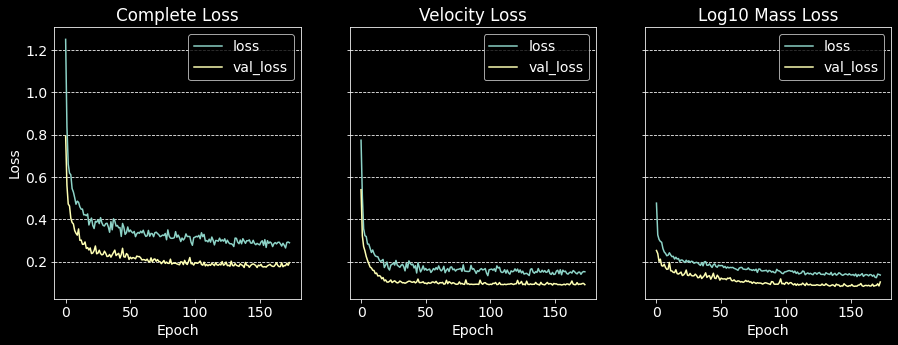

In [11]:
# Show all losses
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

ax1.set_title("Complete Loss")
ax1.plot(model.history.history['loss'], label="loss")
ax1.plot(model.history.history['val_loss'], label="val_loss")
ax1.set_xlabel(r"Epoch")
ax1.set_ylabel(r"Loss")
ax1.grid(axis="y", linestyle="dashed")
ax1.legend()

ax2.set_title("Velocity Loss")
ax2.plot(model.history.history['output_PSU_loss'], label="loss")
ax2.plot(model.history.history['val_output_PSU_loss'], label="val_loss")
ax2.set_xlabel(r"Epoch")
ax2.grid(axis="y", linestyle="dashed")
ax2.legend()

ax3.set_title("Log10 Mass Loss")
ax3.plot(model.history.history['output_mass_loss'], label="loss")
ax3.plot(model.history.history['val_output_mass_loss'], label="val_loss")
ax3.set_xlabel(r"Epoch")
ax3.grid(axis="y", linestyle="dashed")
ax3.legend()

In [12]:
# Compute the test losses
test_losses = model.evaluate(X_test_scaled, y_test_scaled)

10/10 [==============================] - 0s 2ms/step - loss: 3.8648 - output_PSU_loss: 1.9051 - output_mass_loss: 1.9597 - output_PSU_root_mean_squared_error: 1.3803 - output_PSU_mean_absolute_error: 0.8541 - output_mass_root_mean_squared_error: 1.3999 - output_mass_mean_absolute_error: 0.8806


In [13]:
# RMSE (velocity + LOG10 mass)
y_scaler.inverse_transform([[test_losses[3], test_losses[-2]]])

array([[22.59201777,  0.40255847]])

In [14]:
# MAE (velocity + LOG10 mass)
y_scaler.inverse_transform([[test_losses[4], test_losses[-1]]])

array([[17.68036812, -0.16500196]])